### Installs & Imports

In [29]:
import os
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import spacy
from spacy.tokens import Doc
import emoji
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# 1. Named Entity Recognition & Classification

### Training & Validation Sets

#### Distribution Analysis

In [2]:
label_mapping = {
    0: 'O', 1: 'B-CARDINAL', 2: 'B-DATE', 3: 'I-DATE', 4: 'B-PERSON', 5: 'I-PERSON',
    6: 'B-NORP', 7: 'B-GPE', 8: 'I-GPE', 9: 'B-LAW', 10: 'I-LAW', 11: 'B-ORG',
    12: 'I-ORG', 13: 'B-PERCENT', 14: 'I-PERCENT', 15: 'B-ORDINAL', 16: 'B-MONEY',
    17: 'I-MONEY', 18: 'B-WORK_OF_ART', 19: 'I-WORK_OF_ART', 20: 'B-FAC',
    21: 'B-TIME', 22: 'I-CARDINAL', 23: 'B-LOC', 24: 'B-QUANTITY', 25: 'I-QUANTITY',
    26: 'I-NORP', 27: 'I-LOC', 28: 'B-PRODUCT', 29: 'I-TIME', 30: 'B-EVENT',
    31: 'I-EVENT', 32: 'I-FAC', 33: 'B-LANGUAGE', 34: 'I-PRODUCT', 35: 'I-ORDINAL',
    36: 'I-LANGUAGE'
}

In [3]:
# Training data (merge 5 files together - we use the original four training files and valiadation as training data)
# # a new file called 'merged_word_train_val' is created as a result of the merging and conversion of
# sentence instances to word instances and is saved in the folder
train_val_files = ["Training Data/NERC Data/Original/train00.json", "Training Data/NERC Data/Original/train01.json", "Training Data/NERC Data/Original/train02.json",
                    "Training Data/NERC Data/Original/train03.json", "Training Data/NERC Data/Original/valid.json"]

output_file = "Training Data/NERC Data/merged_word_train_val.json"

word_instances = []
sentence_id = 0

for file in train_val_files:
    with open(file, "r", encoding="utf-8") as in_file:
        for line in in_file:
            sentence = json.loads(line)
            tokens = sentence["tokens"]
            ner_tags = sentence["tags"]

            for token_id, (token, ner_tag) in enumerate(zip(tokens, ner_tags)):
                word_instance = {
                    "sentence_id": sentence_id,
                    "token_id": token_id,
                    "token": token,
                    "BIO_NER_tag": label_mapping.get(ner_tag, "O")  # Map numeric tag to IOB format
                }
                word_instances.append(word_instance)
        
            # Increment the sentence ID
            sentence_id += 1  

# Save the transformed data to a new JSON file
with open(output_file, "w", encoding="utf-8") as out_file:
    for instance in word_instances:
        out_file.write(json.dumps(instance) + "\n")

In [4]:
# Validation data (we use the original test data as validation data)
# a new file called 'merged_word_test' is created as a result of the merging and conversion of
# sentence instances to word instances and is saved in the folder
test_file = "Training Data/NERC Data/Original/test.json"
output_file = "Training Data/NERC Data/word_test.json"

word_instances = []
sentence_id = 0

with open(test_file, "r", encoding="utf-8") as in_file:
    for line in in_file:
            sentence = json.loads(line)
            tokens = sentence["tokens"]
            ner_tags = sentence["tags"]

            # Convert sentence instances to word instances 
            for token_id, (token, ner_tag) in enumerate(zip(tokens, ner_tags)):
                word_instance = {
                    "sentence_id": sentence_id,
                    "token_id": token_id,
                    "token": token,
                    "BIO_NER_tag": label_mapping.get(ner_tag, "O")  # Map numeric tag to IOB format
                }
                word_instances.append(word_instance)
        
            # Increment the sentence ID
            sentence_id += 1  

# Save the transformed data to a new JSON file
with open(output_file, "w", encoding="utf-8") as out_file:
    for instance in word_instances:
        out_file.write(json.dumps(instance) + "\n")


In [5]:
def ner_distribution_table(file_path):
    """
    Creates a dataframe showing the count and percentage of each NER tag
    in the given dataset.
    """
    tags_list = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)  
            tags_list.append(data['BIO_NER_tag'])  

    # Count occurrences of each tag
    tag_counts = Counter(tags_list)

    # Convert counts to percentages
    total_tags = sum(tag_counts.values())
    tag_data = []
    for tag, count in tag_counts.items():
        tag_percentage = (count / total_tags) * 100
        tag_info = {"NER Label": tag, "Count": count, "Percentage": tag_percentage}
        tag_data.append(tag_info)
    
    # Create and return DataFrame
    df = pd.DataFrame(tag_data).sort_values(by="Percentage", ascending=False)
    df.reset_index(drop=True, inplace=True)
    df = df.set_index(keys="NER Label") 
  
    return df

In [6]:
ner_distribution_table("Training Data/NERC Data/merged_word_train_val.json")


,Count,Percentage
NER Label,,
O,1066810,86.300317
I-ORG,20582,1.664995
B-GPE,17673,1.429669
B-PERSON,17449,1.411549
I-DATE,15142,1.224922
B-ORG,14560,1.177841
I-PERSON,12542,1.014594
B-DATE,12429,1.005452
B-CARDINAL,8292,0.670787


In [7]:
ner_distribution_table("Training Data/NERC Data/word_test.json")

,Count,Percentage
NER Label,,
O,131814,86.309200
I-ORG,2406,1.575401
B-GPE,2240,1.466708
I-DATE,2011,1.316763
B-PERSON,1988,1.301703
B-ORG,1795,1.175331
B-DATE,1602,1.048958
I-PERSON,1412,0.924550
B-CARDINAL,935,0.612220


### Test Set

In [8]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/NER-test.tsv'
test_data_df = pd.read_csv(file_path, delimiter='\t')

# Count occurrences of each tag
tag_counts = Counter(test_data_df['BIO_NER_tag'])

# Convert counts to percentages
total_tags = sum(tag_counts.values())
tag_data = []
for tag, count in tag_counts.items():
    tag_percentage = (count / total_tags) * 100
    tag_info = {"NER Label": tag, "Count": count, "Percentage": tag_percentage}
    tag_data.append(tag_info)

# Create and return DataFrame
distribution_df = pd.DataFrame(tag_data).sort_values(by="Percentage", ascending=False)
distribution_df.reset_index(drop=True, inplace=True)
distribution_df = distribution_df.set_index(keys="NER Label") 
display(distribution_df)

,Count,Percentage
NER Label,,
O,186,78.481013
B-PERSON,11,4.641350
I-WORK_OF_ART,10,4.219409
B-WORK_OF_ART,9,3.797468
I-PERSON,8,3.375527
B-LOC,7,2.953586
B-ORG,3,1.265823
I-ORG,2,0.843882
I-LOC,1,0.421941


### Feature Engineering

In [9]:
def get_shape(word):
    """
    Helper function that determines the shape of word.
    Inspired by the categories for shape in dataset ner_v2.csv used in Lab 4.
    """
    if word in ["__START__", "__END__"]:
        return "wildcard"
    elif word in string.punctuation:
        return "punctuation"
    elif "-" in word:
        return "contains-hyphen"
    elif "'" in word:
        return "other"
    elif "." in word and word.isupper():
            return "abbreviation"
    elif word.isalpha():
        if word.istitle():
            return "capitalized"
        elif word.islower():
            return "lowercase"
        elif word.isupper():
            return "uppercase"
    elif word.isdigit():
        return "number"
    else:
        return "other"

In [11]:
def data_to_features(df):
    """
     Process a dataframe by adding linguistic features using spaCy.
    - Adds POS tagging, lemmatization and shape features
    - Computes previous/next token and their lemma, POS tag and shape
    """

    # Load English model for POS tagging
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
    nlp.max_length = 7000000  # increase the max length to allow larger inputs

    # Add the POS tags and lemmas
    tokens = df["token"].to_list()
    document = Doc(nlp.vocab, words=tokens)

    # Manually run the tokens through the spaCy pipeline to avoid retokenization
    document = nlp.get_pipe("tok2vec")(document)  
    document = nlp.get_pipe("tagger")(document)  
    document = nlp.get_pipe("attribute_ruler")(document)  
    document = nlp.get_pipe("lemmatizer")(document)  

    pos_tags = []
    lemmas = []
    for token in document:
        pos_tags.append(token.tag_)
        lemmas.append(token.lemma_)
    
    df["POS_tag"] = pos_tags
    df["lemma"] = lemmas

    # Add the previous and next token, their lemmas and their POS tags
    df["prev_token"] = df["token"].shift(1).fillna("__START__")
    df["next_token"] = df["token"].shift(-1).fillna("__END__")
    df["prev_lemma"] = df["lemma"].shift(1).fillna("__START__")
    df["next_lemma"] = df["lemma"].shift(-1).fillna("__END__")
    df["prev_POS_tag"] = df["POS_tag"].shift(1).fillna("__START__")
    df["next_POS_tag"] = df["POS_tag"].shift(-1).fillna("__END__")

    # Add the shape of each word
    df["shape"] = df["token"].apply(get_shape)
    df["prev_shape"] = df["prev_token"].apply(get_shape)
    df["next_shape"] = df["next_token"].apply(get_shape)

    # Reorder the columns
    df = df[["sentence_id", "token_id", "token", "shape",  "POS_tag", "lemma", "BIO_NER_tag", 
        "prev_token", "prev_shape", "prev_POS_tag", "prev_lemma", "next_token", "next_shape",
        "next_POS_tag", "next_lemma"]]
    
    return df

In [10]:
# Put the training and validation data into dataframes
train_data_file = "Training Data/NERC Data/merged_word_train_val.json"
val_data_file = "Training Data/NERC Data/word_test.json"
train_data = []
val_data = []

# Create a dataframe with the training data
with open(train_data_file, "r", encoding="utf-8") as file:
    for line in file:
        train_data.append(json.loads(line))
train_data_df = pd.DataFrame(train_data)

# Create a dataframe with the validation data
with open(val_data_file, "r", encoding="utf-8") as file:
    for line in file:
        val_data.append(json.loads(line))
val_data_df = pd.DataFrame(val_data)

In [12]:
# Create more features from the data
train_data_df = data_to_features(train_data_df)
val_data_df = data_to_features(val_data_df)
test_data_df = data_to_features(test_data_df)

# Save the files with the features
train_data_df.to_csv("Training Data/NERC Data/train_features.csv", index=False, encoding="utf-8")
val_data_df.to_csv("Training Data/NERC Data/val_features.csv", index=False, encoding="utf-8")
test_data_df.to_csv("Test Data/NER_test_features.csv", index=False, encoding="utf-8")

In [13]:
# maybe try using word embeddings...

### Model Training

### Model Evaluation of the Test Set

# 2. Sentiment Analysis

### Training & Validation Sets

In [30]:
#MERGING the original train and val to use together as training
train_df = pd.read_csv("Training Data/Sentiment Analysis Data/train_df.csv")  
val_df = pd.read_csv("Training Data/Sentiment Analysis Data/val_df.csv") 

#merge
merged_df = pd.concat([train_df, val_df], ignore_index=True)

#save in new csv file
merged_df.to_csv("Training Data/Sentiment Analysis Data/merged_new_train.csv", index=False)

In [31]:
#CLEANING and saving to new files (cleaned_train; cleaned_val)
def clean_sentiment(text):
    text = str(text) 
    #convert to lowercase
    text = text.lower()
    #remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    #remove mentions and hastags
    text = re.sub(r"@\w+|#\w+", "", text)
    #remove special characters (punctuation still there)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", "", text)  
    #remove spaces
    text = re.sub(r'\s+', ' ', text).strip()  
    #optional: remove emojis, replace them with text 
    #text = emoji.demojize(text, delimiters=(" ", " ")) ###TBC!
    return text

training_data = pd.read_csv("Training Data/Sentiment Analysis Data/merged_new_train.csv")
training_data["text"] = training_data["text"].apply(clean_sentiment)  
training_data.to_csv("Training Data/Sentiment Analysis Data/cleaned_train.csv", index=False)

val_data = pd.read_csv("Training Data/Sentiment Analysis Data/new_val.csv")
val_data["text"] = val_data["text"].apply(clean_sentiment)  
val_data.to_csv("Training Data/Sentiment Analysis Data/cleaned_val.csv", index=False)

#### Distribution Analysis

In [32]:
def visualize_sentiment_distribution(file_path):
    '''
        TBA
    '''
    df = pd.read_csv(file_path)
    sentiment_counts = Counter(df['sentiment'])
    
    total_labels = sum(sentiment_counts.values())
    sentiment_percentages = {label: (count / total_labels) * 100 for label, count in sentiment_counts.items()}

    sorted_labels = sorted(sentiment_percentages.items(), key=lambda x: x[1], reverse=True)
    labels, percentages = zip(*sorted_labels)
    color_map = {"neutral": "#FFE119", "positive": "#F032E6", "negative": "#46F0F0"}
    colors = [color_map[label] for label in labels]

    # Create the bar chart (horizontal)
    plt.figure(figsize=(8, 5))
    sns.barplot(y=labels, x=percentages, hue=labels, palette=colors, legend=False)
    for index, value in enumerate(percentages):
        plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=9)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Label')
    plt.xlim(0, 45)
    filename = os.path.basename(file_path) 
    plt.title(f'Distribution of Sentiment Labels in {filename}')
    plt.show()

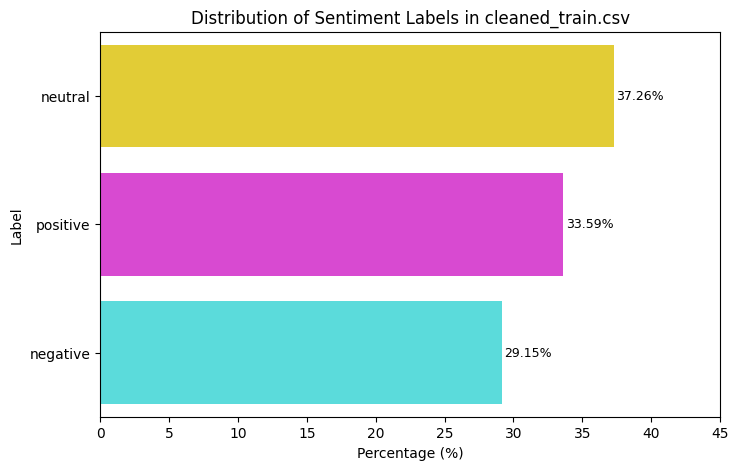

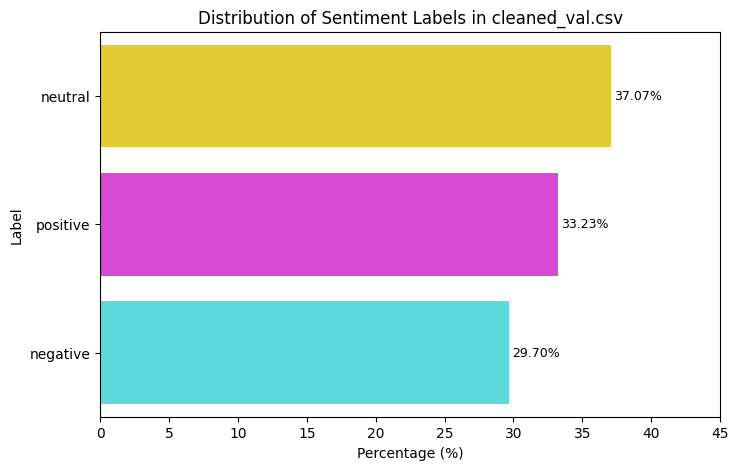

In [33]:
# Old files
# files = ['Training Data/Sentiment Analysis Data/train_df.csv', 'Training Data/Sentiment Analysis Data/val_df.csv', 'Training Data/Sentiment Analysis Data/test_df.csv']

# New (cleaned+merged) files
files = ['Training Data/Sentiment Analysis Data/cleaned_train.csv', 'Training Data/Sentiment Analysis Data/cleaned_val.csv']

for file in files:
    visualize_sentiment_distribution(file)

### Test Set (the same test set is used for both sentiment analysis and topic modeling)

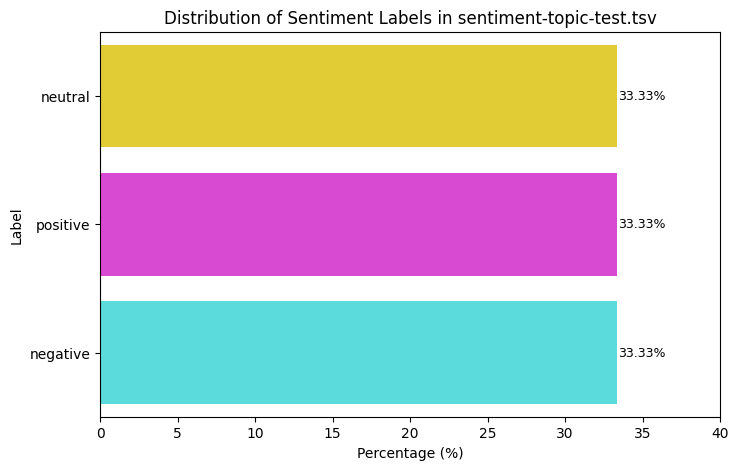

In [34]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/sentiment-topic-test.tsv'
df = pd.read_csv(file_path, delimiter='\t')

sentiment_counts = Counter(df['sentiment'])

total_labels = sum(sentiment_counts.values())
sentiment_percentages = {label: (count / total_labels) * 100 for label, count in sentiment_counts.items()}

ordered_labels = ["neutral", "positive", "negative"]
percentages = [sentiment_percentages[label] for label in ordered_labels]
color_map = {"neutral": "#FFE119", "positive": "#F032E6", "negative": "#46F0F0"}
colors = [color_map[label] for label in ordered_labels]

# Create the bar chart (horizontal)
plt.figure(figsize=(8,5))
sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
for index, value in enumerate(percentages):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)
plt.xlabel('Percentage (%)')
plt.ylabel('Label')
plt.xlim(0, 40) 
filename = os.path.basename(file_path) 
plt.title(f'Distribution of Sentiment Labels in {filename}')
plt.show()

### VADER on Test Set

In [35]:
nlp = spacy.load("en_core_web_sm")
vader_model = SentimentIntensityAnalyzer()

def vader_output_to_label(vader_output):
    """
    Convert VADER's compound score to sentiment labels.
    """
    compound = vader_output['compound']
    
    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    else:
        return 'positive'

# There is an option to turn on and off preprocessing of VADER input (preprocess=False/True). 
# Without preprocessing, the performance increases, but it isn't a huge change in terms of number of misclassified sentences.
def run_vader(textual_unit, lemmatize=False, parts_of_speech_to_consider=None, verbose=False, preprocess=False):
    """
    Run VADER on a sentence with optional lemmatization and POS filtering.

    Params:
        preprocess - enables or disables spaCy preprocessing before passing a sentence to VADER
    """
    if preprocess == True:
        doc = nlp(textual_unit)
        input_to_vader = []

        for sent in doc.sents:
            for token in sent:
                to_add = token.text
                if lemmatize:
                    to_add = token.lemma_
                    if to_add == '-PRON-': 
                        to_add = token.text
                if parts_of_speech_to_consider:
                    if token.pos_ in parts_of_speech_to_consider:
                        input_to_vader.append(to_add) 
                else:
                    input_to_vader.append(to_add)

        scores = vader_model.polarity_scores(' '.join(input_to_vader))

        if verbose >= 1:
            print("\nINPUT SENTENCE:", textual_unit)
            print("INPUT TO VADER:", input_to_vader)
            print("VADER OUTPUT:", scores)
    else: 
        scores = vader_model.polarity_scores(textual_unit) 
    
        if verbose >= 1:
            print("\nINPUT SENTENCE:", textual_unit)
            print("VADER OUTPUT:", scores)

    return scores

def evaluate_vader_on_testset(file_path, lemmatize=False, parts_of_speech_to_consider=None, verbose=False, preprocess=False, print_report=False, misclassification_breakdown=False):
    """
    Run VADER on the test set and compare with ground truth sentiment labels.
    """
    df = pd.read_csv(file_path, delimiter="\t")

    # Dictionaries to store error counts and details for misclassified sentences
    misclassified_counts = {"positive": 0, "negative": 0, "neutral": 0}
    misclassified_sentences = {"positive": [], "negative": [], "neutral": []}

    actual_sentiments = df["sentiment"].tolist()
    sentences = df["sentence"].tolist()

    predicted_sentiments = []
    
    # Run VADER
    for i in range(len(sentences)):
        vader_output = run_vader(sentences[i], lemmatize=lemmatize, parts_of_speech_to_consider=parts_of_speech_to_consider, verbose=verbose, preprocess=preprocess)
        predicted_label = vader_output_to_label(vader_output)
        predicted_sentiments.append(predicted_label)

        true_label = actual_sentiments[i]
        
        # Check for misclassification
        if true_label != predicted_label:
            misclassified_counts[true_label] += 1
            misclassified_sentences[true_label].append((sentences[i], predicted_label, vader_output))

    # If the option is selected, show detailed misclassification breakdown
    if misclassification_breakdown == True:
        print("\nMisclassification Summary")
        print("-" * 50)
        for sentiment, count in misclassified_counts.items():
            print(f"{sentiment.capitalize()} misclassified: {count}")
        print("=" * 50)
        for sentiment, errors in misclassified_sentences.items():
            print(f"\nMisclassified {sentiment.capitalize()} Sentences")
            print("~" * 50)
            for sentence, predicted, vader_scores in errors:
                print(f"\nSentence: {sentence}")
                print(f"Expected: {sentiment}; Predicted: {predicted}")
                print(f"VADER Scores: {vader_scores}")
                print("*" * 50)

    # If the option is selected, show classification report
    if print_report == True:
        print("\nVADER Sentiment Analysis Performance:")
        print(classification_report(actual_sentiments, predicted_sentiments))

In [36]:
# First print only classification report for better visibility
df_vader_results = evaluate_vader_on_testset(file_path='Test Data/sentiment-topic-test.tsv', lemmatize=False, parts_of_speech_to_consider=None, 
                                             verbose=False, preprocess=False, print_report=True, misclassification_breakdown=False)

# Run again with detailed breakdown of misclassifications for detailed analysis, if needed
df_vader_results = evaluate_vader_on_testset(file_path='Test Data/sentiment-topic-test.tsv', lemmatize=False, parts_of_speech_to_consider=None, 
                                             verbose=False, preprocess=False, print_report=False, misclassification_breakdown=True)


VADER Sentiment Analysis Performance:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       0.33      0.50      0.40         6
    positive       0.43      0.50      0.46         6

    accuracy                           0.33        18
   macro avg       0.25      0.33      0.29        18
weighted avg       0.25      0.33      0.29        18


Misclassification Summary
--------------------------------------------------
Positive misclassified: 3
Negative misclassified: 6
Neutral misclassified: 3

Misclassified Positive Sentences
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Sentence: The atmosphere at the stadium tonight was electric.
Expected: positive; Predicted: neutral
VADER Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
**************************************************

Sentence: It had me hooked from the first chapter.
Expected: positive; Predicted: neutral
VADER Scores: {'neg': 0.0, '

### Feature Engineering

### Model Training

# 3. Topic Classification

### Training & Validation Sets

#### Distribution Analysis

In [19]:
def visualize_topic_distribution(file_path):
    '''
        TBA
    '''
    df = pd.read_csv(file_path)

    topic_counts = Counter(df['label'])

    total_labels = sum(topic_counts.values())
    topic_percentages = {label: (count / total_labels) * 100 for label, count in topic_counts.items()}
    
    ordered_labels = ["sports", "movie", "book"]
    percentages = [topic_percentages[label] for label in ordered_labels]
    color_map = {"sports": "#0082C8", "movie": "#3CB44B", "book": "#E6194B"}
    colors = [color_map[label] for label in ordered_labels]

    # Create the bar chart (horizontal)
    plt.figure(figsize=(8, 5))
    sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
    for index, value in enumerate(percentages):
        plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=9)
    plt.xlabel('Percentage (%)')
    plt.ylabel('Label')
    plt.xlim(0, 45) 
    filename = os.path.basename(file_path) 
    plt.title(f'Distribution of Topic Labels in {filename}')
    plt.show()

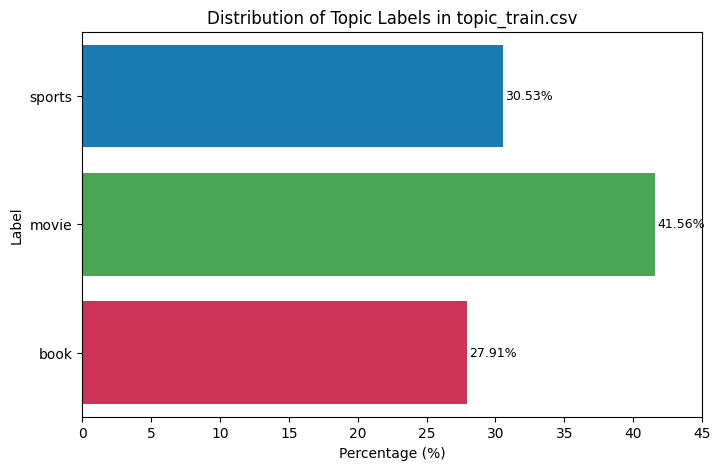

In [20]:
# This dataset did not come split; therefore, plot the whole thing here, and we can call the vis function for each split after, if we want to plot each part
files = ['Training Data/Topic Classification Data/topic_train.csv']

for file in files:
    visualize_topic_distribution(file)

### Training & Validation Sets

In [21]:
# perhaps filter reviews that are one-word like 'good', 'great' 
# format the reviews text the same way, some of them are within '', others are not, make all without ''
# make graphs of data distribution

### Test Set (the same test set is used for both sentiment analysis and topic modeling)

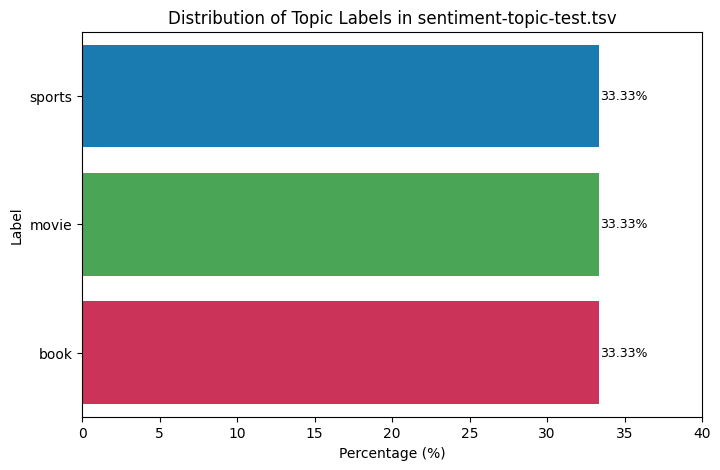

In [22]:
# Distribution of provided Test set (from .tsv file)
file_path = 'Test Data/sentiment-topic-test.tsv'
df = pd.read_csv(file_path, delimiter='\t')

topic_counts = Counter(df['topic'])

total_labels = sum(topic_counts.values())
topic_percentages = {label: (count / total_labels) * 100 for label, count in topic_counts.items()}

ordered_labels = ["sports", "movie", "book"]
percentages = [topic_percentages[label] for label in ordered_labels]
color_map = {"sports": "#0082C8", "movie": "#3CB44B", "book": "#E6194B"}
colors = [color_map[label] for label in ordered_labels]

# Create the bar chart (horizontal)
plt.figure(figsize=(8, 5))
sns.barplot(y=ordered_labels, x=percentages, hue=ordered_labels, palette=colors, legend=False)
for index, value in enumerate(percentages):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center', fontsize=9)
plt.xlabel('Percentage (%)')
plt.ylabel('Label')
plt.xlim(0, 40) 
filename = os.path.basename(file_path) 
plt.title(f'Distribution of Topic Labels in {filename}')
plt.show()

### Feature Engineering

### Model Training